<a href="https://colab.research.google.com/github/luphone04/DeepLearningABAC/blob/main/Week1/MNIST_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MNIST NN from scratch

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')

In [21]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [22]:
Y_train

array([2, 4, 8, ..., 3, 2, 8])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [24]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [25]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [26]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 600)

Iteration:  0
[4 7 7 ... 7 7 7] [2 4 8 ... 3 2 8]
0.09631707317073171
Iteration:  10
[2 4 7 ... 0 2 4] [2 4 8 ... 3 2 8]
0.33014634146341465
Iteration:  20
[1 4 1 ... 0 2 4] [2 4 8 ... 3 2 8]
0.45146341463414635
Iteration:  30
[1 4 9 ... 0 2 4] [2 4 8 ... 3 2 8]
0.548609756097561
Iteration:  40
[1 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.6330975609756098
Iteration:  50
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.7394146341463415
Iteration:  60
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.7890487804878049
Iteration:  70
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.809439024390244
Iteration:  80
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8228780487804878
Iteration:  90
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8325609756097561
Iteration:  100
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8410731707317073
Iteration:  110
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8470243902439024
Iteration:  120
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8524634146341463
Iteration:  130
[2 4 8 ... 3 2 4] [2 4 8 ... 3 2 8]
0.8572682926829268
Iteration:  140


In [27]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [2]
Label:  2


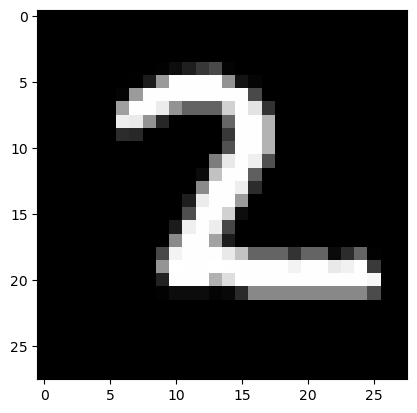

Prediction:  [4]
Label:  4


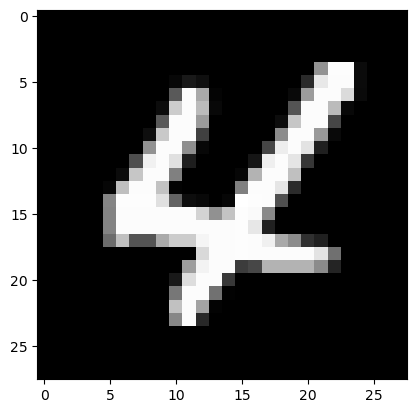

Prediction:  [8]
Label:  8


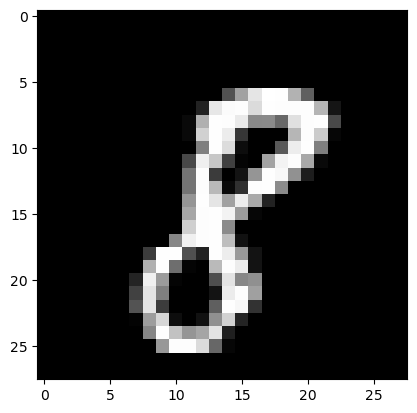

Prediction:  [6]
Label:  6


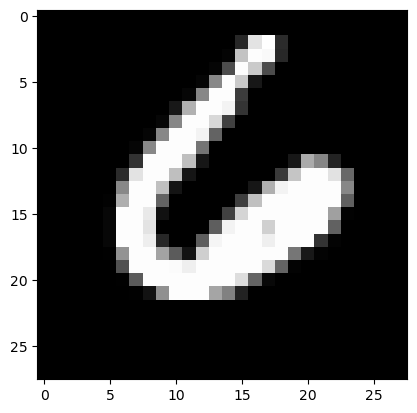

In [29]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

Finally, let's find the accuracy on the dev set:

In [31]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[3 4 8 8 8 7 1 3 4 0 1 9 8 3 0 5 1 7 3 3 4 7 2 1 4 6 1 7 9 6 8 1 4 4 2 2 3
 7 0 2 0 9 7 3 7 4 9 2 0 0 6 5 8 1 9 3 2 6 4 4 8 7 7 4 4 7 4 1 3 0 1 5 0 6
 9 9 6 4 8 4 3 5 5 9 4 8 2 3 5 7 2 0 3 6 2 5 4 0 0 1 0 9 3 5 0 4 7 2 5 8 6
 9 5 1 1 6 1 3 0 0 9 5 4 6 7 3 6 7 6 2 0 3 1 3 6 1 9 5 0 4 3 3 1 3 5 6 7 5
 5 9 4 9 4 4 3 6 7 6 4 1 8 8 4 9 1 8 8 7 5 2 0 6 3 4 6 6 6 6 0 5 5 6 0 4 2
 0 9 0 6 4 2 1 1 2 5 8 7 8 2 7 9 3 8 8 1 0 4 3 3 7 4 9 5 0 4 7 0 3 4 4 9 7
 4 1 6 9 6 1 2 8 1 2 6 4 2 6 1 7 3 1 7 9 8 6 3 0 7 4 5 2 7 6 7 6 8 1 4 0 1
 1 3 6 2 1 1 3 3 7 9 5 9 5 3 8 1 5 6 9 2 3 6 1 5 8 0 1 2 8 4 0 2 2 7 9 0 3
 5 5 5 8 7 1 3 9 5 7 6 4 1 3 7 6 8 3 5 4 3 5 6 8 2 2 9 2 5 7 6 1 7 3 7 9 4
 4 4 1 7 7 1 0 4 9 4 4 4 2 1 2 0 7 8 0 1 6 1 8 6 7 6 0 5 4 3 9 4 7 3 1 6 7
 7 0 6 6 6 2 0 9 4 0 0 3 9 3 0 4 9 2 3 5 4 0 5 6 0 7 2 7 1 2 0 0 7 2 1 4 1
 2 6 8 7 2 9 2 0 5 1 8 2 6 7 0 9 2 3 8 3 2 4 5 1 8 1 8 1 9 8 5 6 2 4 1 9 4
 8 2 0 8 4 9 9 6 8 9 1 2 5 6 1 8 3 8 2 8 3 8 0 7 0 2 0 6 7 8 4 7 1 1 8 5 7
 2 2 0 1 1 6 9 6 4 6 6 3 

0.887